# 3-D 10 particles using Anderson Thermostat

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits import mplot3d
import math
from sympy import *
import random

In [3]:
# functions 

def init(n,L,s,t):
    X = np.random.uniform(0.001,L,3*n)
    V = np.zeros(3*n)
    H = np.zeros(s)
    KE = np.zeros(s)
    PE = np.zeros(s)
    PLTX = np.zeros(s)
    PLTV = np.zeros(s)
    return n, L, X, V, s, t,H,KE,PE,PLTX,PLTV

def pe(x):
    return 0.5*k*x*x

def ke_sys(V,n):
    velocities_squared = V[::3]**2 + V[1::3]**2 + V[2::3]**2
    te = np.sum(velocities_squared) * 0.5
    return te

def pe_sys(X, n):
    te = 0
    for i in range(0, 3 * n, 3):
        for j in range(0, 3 * n, 3):
            if(i>= j):
                continue
            dist = (X[i] - X[j])*(X[i] - X[j]) + (X[i+1] - X[j+1])*(X[i+1] - X[j+1]) + (X[i+2] - X[j+2])*(X[i+2] - X[j+2])
            dist = np.sqrt(dist)
            te = te + pe(dist)
    return te
    
def pbc(X,V,n,L):
    for i in range(n):
        if(X[i] >= L):
            if(V[i]>=0):
                V[i] = - V[i]
        if(X[i] <= 0):
            if(V[i]<=0):
                V[i] = - V[i]

def Anderson(V,n,j,t,sigma):
    nu = 10
    x = 0
    prob_col = t*nu
    for i in range(0, 3 * n, 3):
        if(random.uniform(0,1) <= prob_col):  # poison for time 
            x = x+1
            V[i] = np.random.normal(0, sigma)
            V[i+1] = np.random.normal(0, sigma)
            V[i+2] = np.random.normal(0, sigma)
    ax = 0
    ay = 0
    az = 0
    for i in range(0, 3 * n, 3):
        ax += V[i]
        ay += V[i+1]
        az += V[i+2]
    ax = ax/n
    ay = ay/n
    az = az/n
    for i in range(0, 3 * n, 3):
        V[i] = V[i]-ax
        V[i+1] = V[i+1]-ay
        V[i+2] = V[i+2]-az
    return x
    
def Velocity_rescale(ke_T,V,n):
    v_scale = np.sqrt(ke_T/ke_sys(V,n))
    ax = 0
    ay = 0
    az = 0
    #V*=v_scale
    for i in range(0, 3 * n, 3):
        V[i] = v_scale*V[i]
        V[i+1] = v_scale*V[i+1]
        V[i+2] = v_scale*V[i+2]
        ax += V[i]
        ay += V[i+1]
        az += V[i+2]
    ax = ax/n
    ay = ay/n
    az = az/n
    for i in range(0, 3 * n, 3):
        V[i] = V[i]-ax
        V[i+1] = V[i+1]-ay
        V[i+2] = V[i+2]-az

def Berendsen(ke_T,V,n,t,tau):
    v_scale = np.sqrt(1 + (t/tau)*((ke_T/ke_sys(V,n)) -1))
    ax = 0
    ay = 0
    az = 0
    for i in range(0, 3 * n, 3):
        V[i] = v_scale*V[i]
        V[i+1] = v_scale*V[i+1]
        V[i+2] = v_scale*V[i+2]
        ax += V[i]
        ay += V[i+1]
        az += V[i+2]
    ax = ax/n
    ay = ay/n
    az = az/n
    for i in range(0, 3 * n, 3):
        V[i] = V[i]-ax
        V[i+1] = V[i+1]-ay
        V[i+2] = V[i+2]-az


In [4]:
# Force & PE calculations
k = 0.1
x = symbols('x')
f = pe(x)
force = diff(f, x)
F = lambdify(x, force)

In [5]:
# init
n,L,X,V,s,t,H,KE,PE,PLTV,PLTX = init(10,6,10000,0.01) # dict pass to object 

# Calculate some sigma for Anderson, sigma = square root of KbT, let KE = PE/3 at T and KE = 3/2 KbT
sigma = 0.1*np.sqrt((pe_sys(X,n)*2)/9)
PDF = np.zeros(s)

# Berendsen & Velocity rescale, constant temp T lets assume the KE & tau for Berendsen 
ke_T = pe_sys(X,n)/4.5
tau = 10*t

# Propagator 

for j in range(s):
    KE[j] = ke_sys(V,n)
    PE[j] = pe_sys(X,n)
    H[j] = KE[j] + PE[j]
    PLTX[j] = X[3]
    PLTV[j] = V[3]
    for i in range(0, 3 * n, 3):
        c_x = X[i]
        c_y = X[i + 1]
        c_z = X[i + 2]
        c_vx = V[i]
        c_vy = V[i + 1]
        c_vz = V[i + 2]
        ax = 0
        ay = 0
        az = 0
        for l in range(0, 3 * n, 3):
            ax = ax - F(X[i]-X[l])
            ay = ay - F(X[i+1]-X[l+1])
            az = az - F(X[i+2]-X[l+2])
        X[i] = c_x + (t * c_vx) + (t * t * ax) / 2
        X[i + 1] = c_y + (t * c_vy) + (t * t * ay) / 2
        X[i + 2] = c_z + (t * c_vz) + (t * t * az) / 2
        for l in range(0, 3 * n, 3):
            ax = ax - F(X[i]-X[l])
            ay = ay - F(X[i+1]-X[l+1])
            az = az - F(X[i+2]-X[l+2])
        V[i] = c_vx + (ax * t) / 2
        V[i + 1] = c_vy + (ay * t) / 2
        V[i + 2] = c_vz + (az * t) / 2
    #Velocity_rescale(ke_T,V,n)
    PDF[j] = Anderson(V,n,j,t,sigma)
    #Berendsen(ke_T,V,n,t,tau)
    pbc(X,V,n,L)

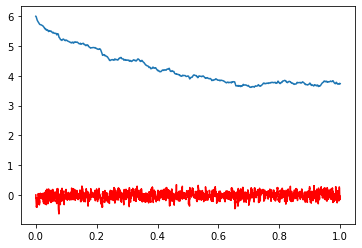

In [6]:
x1 = np.linspace(0, 1, s)
plt.plot(x1, PLTV,color='red')
plt.plot(x1, PLTX)

Fitted Rate Parameter: 0.49892578124999953


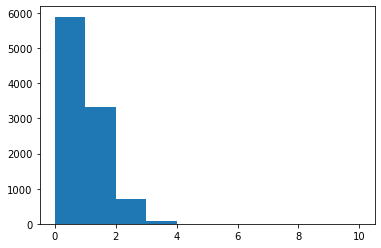

In [7]:
plt.hist(PDF, bins = [0,1,2,3,4,5,6,7,8,9,10])
from scipy.stats import poisson
from scipy.optimize import minimize

# Given array of values
data = PDF

# Define the negative log-likelihood function
def neg_log_likelihood(params):
    rate = params[0]
    return -np.sum(poisson.logpmf(data, rate))

# Initial guess for the rate parameter
initial_guess = [1.0]

# Optimize the negative log-likelihood function
result = minimize(neg_log_likelihood, initial_guess, method='Nelder-Mead')

# Fitted rate parameter
fitted_rate = result.x[0]

print("Fitted Rate Parameter:", fitted_rate)

# Lambda is n*nu*dt, where nu*dt is the probability of each particle colliding at each step, and n particles in each step. Hence verified poisson


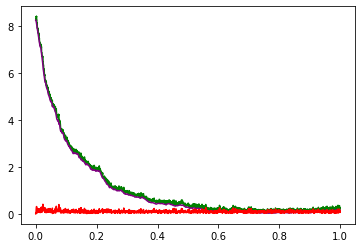

In [8]:
plt.plot(x1, H,color='green')
plt.plot(x1, PE,color='purple')
plt.plot(x1, KE, color='red')

In [141]:
# Plotting Function .plot for an object H/KE/PE/PS
# Vectorized 
# thermostat in variable 
# Pip custom install

In [ ]:
# explicit energy function, force der, modular numpy array, X[123],V[123]
# propagator function 
# init X,V,n,L
# PBC condt
# Thermostat Berrenson, Andreson, Vel Rescale